In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Importing libraries

In [55]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from skimage.measure import regionprops_table, label
from skimage.measure import find_contours
from skimage.draw import polygon_perimeter
from skimage.feature import hog
from tensorflow import keras
from tensorflow.keras import backend as k
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img

## Q1

#### SIFT is a technique for detecting salient, stable feature points in an image. For every such point, it also provides a set of “features” that “characterize/describe” a small image region around the point. These features are invariant to rotation and scale.
#### Steps of SIFT algorithm
#### 1. Determine approximate location and scale of salient feature points (also called keypoints)
#### 2. Refine their location and scale
#### 3. Determine orientation(s) for each keypoint
#### 4. Determine descriptors for each keypoint.
#### SIFT features have a significant benefit over edge or hog features in that they are unaffected by picture size or orientation. Over the scale-space pyramid, we employ the DoG technique.

## Q2

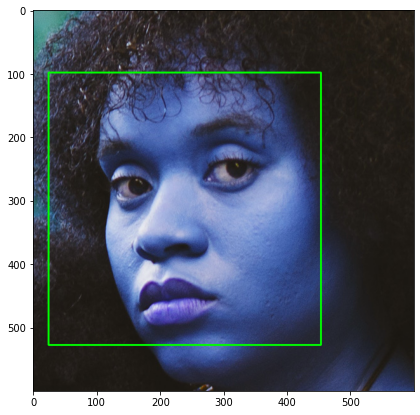

In [112]:
image=cv2.imread("/content/drive/MyDrive/cvcodingassignment/input/training_real/real_00010.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "/haarcascade_frontalface_alt2.xml")
detected_faces = face_cascade.detectMultiScale(gray)
for (column, row, width, height) in detected_faces:
  cv2.rectangle(image, (column, row),(column + width, row + height), (0, 255, 0), 2)
plt.imshow(image)

## Q3

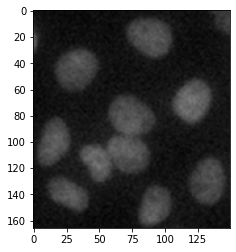

In [3]:
im = cv2.imread("/content/drive/MyDrive/cvcodingassignment/tounching_grayscale.png")
plt.imshow(im)

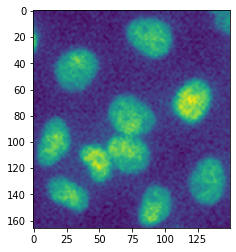

In [4]:
im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY) # converting to grayscale
plt.imshow(im)

In [5]:
# Reshaping the image into a 2D array of pixels and 3 color values (RGB)
pixel_vals = im.reshape((-1,3))
 
# Convert to float type
pixel_vals = np.float32(pixel_vals)

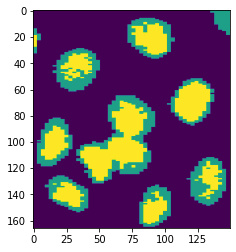

In [6]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85)
 
# then perform k-means clustering wit h number of clusters defined as 3
#also random centres are initially choosed for k-means clustering
k = 3
retval, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
 
# convert data into 8-bit values
centers = np.uint8(centers)
segmented_data = centers[labels.flatten()]
 
# reshape data into the original image dimensions
segmented_image = segmented_data.reshape((im.shape))
 
plt.imshow(segmented_image)

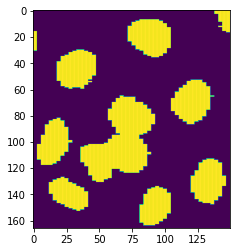

In [7]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85)
 
# then perform k-means clustering wit h number of clusters defined as 3
#also random centres are initially choosed for k-means clustering
k = 2
retval, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
 
# convert data into 8-bit values
centers = np.uint8(centers)
segmented_data = centers[labels.flatten()]
 
# reshape data into the original image dimensions
segmented_image = segmented_data.reshape((im.shape))
 
plt.imshow(segmented_image)

In [8]:
from sklearn.cluster import KMeans
# Preprocess for KMeans implementation
h, w = im.shape
trans_img = [[i, j, im[i, j]] for i in range(h) for j in range(w)]
# 300 iters * pixels, very slow
kmeans = KMeans(n_clusters=12, random_state=52).fit(trans_img)
trans_img_tag = kmeans.predict(trans_img)
print(kmeans.cluster_centers_)

[[ 30.3070922   62.57163121  71.66950355]
 [143.53500802  66.11758418  20.76750401]
 [ 95.84757835 118.47222222  22.89636752]
 [ 41.8254717   74.7004717   20.58215409]
 [115.77        36.00894737  78.02789474]
 [146.90420272 122.02904821  22.48393078]
 [ 28.30298819 125.64211258  22.56845031]
 [138.14143646  19.0558011   25.2718232 ]
 [ 18.62870159  26.14897494  18.37312073]
 [ 75.96909159  28.97926875  24.81605729]
 [ 81.27736451  92.01540914  80.76673751]
 [137.39519159 113.45529677  68.75582269]]


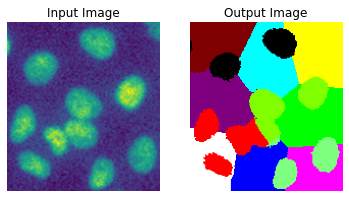

In [9]:
# Post-process to display output of clusters
img_process = np.zeros((h, w, 3), dtype="uint8")

for i, e in enumerate(trans_img_tag):
    x, y = divmod(i, w)
    r, g, b = (e & 4) / 4, (e & 2) / 2, e & 1
    if e & 8:
        r, g, b = 0.5, g, b / 2
    img_process[x, y] = r * 255, g * 255, b * 255

plt.subplot(122)
plt.title("Output Image")
plt.axis("off")
plt.imshow(img_process)
plt.subplot(121)
plt.title("Input Image")
plt.axis("off")
plt.imshow(im)
plt.show()

## Q4

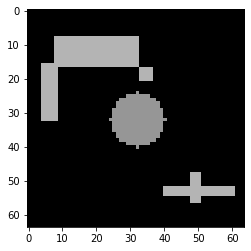

In [10]:
img = cv2.imread("/content/drive/MyDrive/cvcodingassignment/shapes.png")
plt.imshow(img)

In [11]:
print(img.shape)

(64, 64, 3)


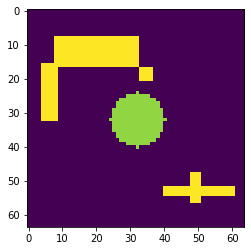

In [12]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img)
plt.show()

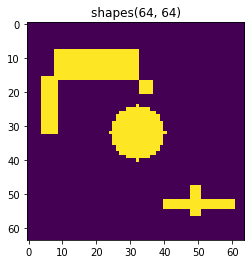

In [13]:
# Otsu's thresholding
_, img = cv2.threshold(img, 120, 255, cv2.THRESH_BINARY)
plt.imshow(img)
plt.title(f"shapes{img.shape}")
plt.show()

In [14]:
from skimage.measure import regionprops_table, label
labeled = label(img > 0)  # ensuring that the input is binary
data = regionprops_table(labeled,properties=("label", "eccentricity", "bbox"))
pd.DataFrame(data)

label  eccentricity  bbox-0  bbox-1  bbox-2  bbox-3
0      1      0.866945       8       4      33      37
1      2      0.000000      24      24      41      41
2      3      0.948645      48      40      57      61

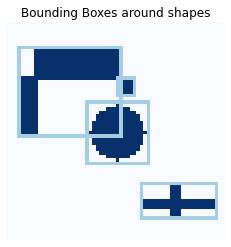

In [15]:
from skimage.measure import find_contours
from skimage.draw import polygon_perimeter

contours = find_contours(img, 0.5)   # Finding Contours
bounding_boxes = []

for contour in contours:
    Xmin = np.min(contour[:, 0])
    Xmax = np.max(contour[:, 0])
    Ymin = np.min(contour[:, 1])
    Ymax = np.max(contour[:, 1])

    bounding_boxes.append([Xmin, Xmax, Ymin, Ymax])    # get bounding-boxes for every contour

with_boxes = np.copy(img)
for box in bounding_boxes:
    r = [box[0], box[1], box[1], box[0], box[0]]
    c = [box[3], box[3], box[2], box[2], box[3]]
    rr, cc = polygon_perimeter(r, c, with_boxes.shape)
    with_boxes[rr, cc] = 90                            # setting color gray

plt.axis("off")
plt.imshow(with_boxes, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Bounding Boxes around shapes")
plt.show()

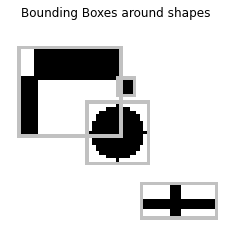

In [16]:
plt.axis("off")
plt.imshow(with_boxes, interpolation="nearest", cmap=plt.cm.Greys)
plt.title("Bounding Boxes around shapes")
plt.show()

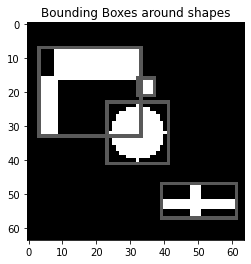

In [17]:
plt.imshow(with_boxes, interpolation="nearest", cmap=plt.cm.gray)
plt.title("Bounding Boxes around shapes")
plt.show()

## Q5

#### SURF descriptor
#### The SURF algorithm is in itself based on two consecutive steps (feature detection and description)
#### 1. Feature detection
#### During the detection step, the local maxima in the box-space of the “determinant of Hessian” operator are used to select interest point candidates. These candidates are then validated if the response is above a given threshold. Both the scale and location of these candidates are then refined using quadratic fitting. Typically, a few hundred interest points are detected in a megapixel image
#### 2. Feature description
#### The purpose of this step is to build a descriptor of the neighborhood of each point of interest that is invariant to view-point changes.

### Harris Corner

Original Dimensions :  (2835, 2126, 3)
Resized Dimensions :  (283, 212, 3)


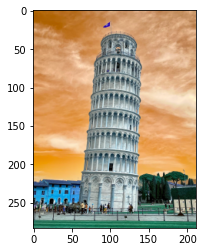

In [18]:
img = cv2.imread("/content/drive/MyDrive/cvcodingassignment/pexels-nico-siegl-11741176.jpg")
print('Original Dimensions : ',img.shape)
 
scale_percent = 10 # percent of original size
width = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)
dim = (width, height)
  
# resize image
resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
 
print('Resized Dimensions : ',resized.shape)
 
plt.imshow(resized)

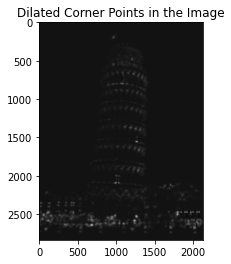

In [19]:
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_gray = np.float32(img_gray) 
d_cor = cv2.cornerHarris(img_gray, 29,29, 0.02)   # Detect corners
d_cor = cv2.dilate(d_cor, None)                   # Dilate corner image to enhance corner points
plt.imshow(d_cor, cmap="gray")
plt.title("Dilated Corner Points in the Image")
plt.show()

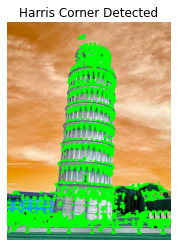

In [20]:
thresh = 0.0055 * d_cor.max()      # free parameter to tweak wrt image
corner_image = np.copy(img)        # Create an image copy to draw corners on
for j in range(0, d_cor.shape[0]): # Iterate through all the corners and draw them on the image if they pass the threshold
    for i in range(0, d_cor.shape[1]):
        if d_cor[j, i] > thresh:
            cv2.circle(corner_image, (i, j), 1, (0, 255, 0), 1)

plt.imshow(corner_image)
plt.title("Harris Corner Detected")
plt.axis("off")
plt.show()

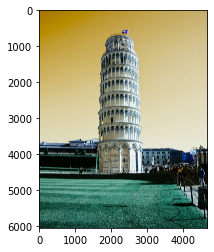

In [21]:
img = cv2.imread("/content/drive/MyDrive/cvcodingassignment/pexels-spolyakov-11117621.jpg")
plt.imshow(img)

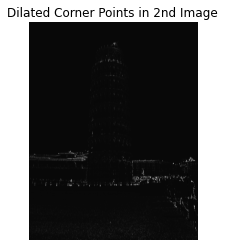

In [22]:
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_gray = np.float32(img_gray)
d_cor = cv2.cornerHarris(img_gray,27, 29, 0.012)  # Detect corners
d_cor = cv2.dilate(d_cor, None)                # Dilate corner image to enhance corner points
plt.imshow(d_cor, cmap="gray")
plt.title("Dilated Corner Points in 2nd Image")
plt.axis("off")
plt.show()

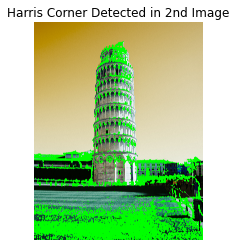

In [23]:
thresh = 0.0050 * d_cor.max()  # free parameter to tweak wrt image
# Create an image copy to draw corners on
corner_image = np.copy(img)
# Iterate through all the corners and draw them on the image if they pass the threshold
for j in range(0, d_cor.shape[0]):
    for i in range(0, d_cor.shape[1]):
        if d_cor[j, i] > thresh:
            # image, center pt, radius, color, thickness
            cv2.circle(corner_image, (i, j), 1, (0, 255, 0), 1)

plt.imshow(corner_image)
plt.title("Harris Corner Detected in 2nd Image")
plt.axis("off")
plt.show()

### SURF

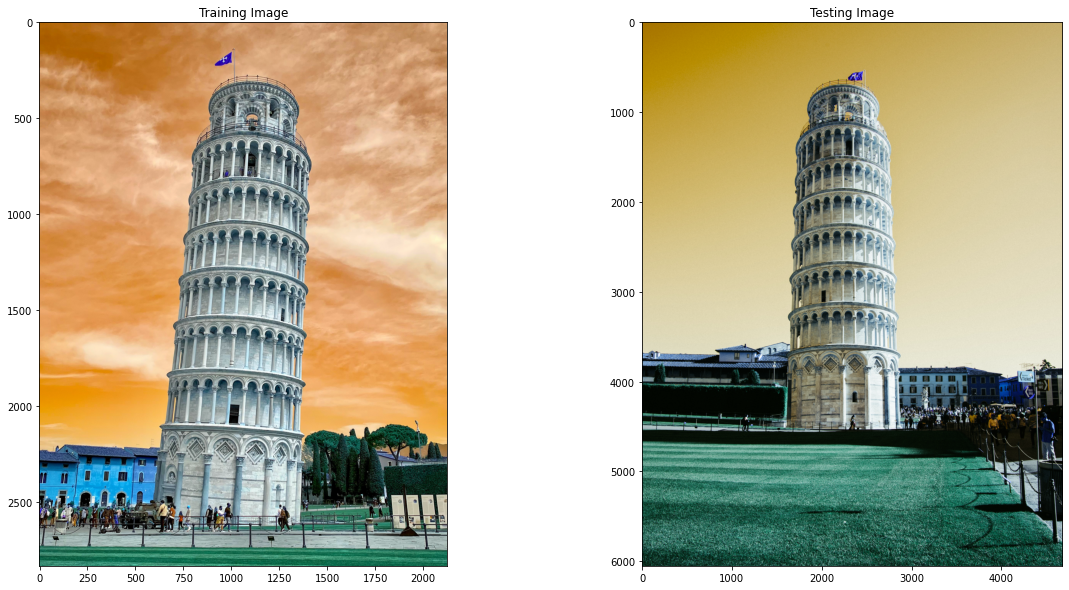

In [24]:
img_train = cv2.imread("/content/drive/MyDrive/cvcodingassignment/pexels-nico-siegl-11741176.jpg")
gray_train = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

img_test = cv2.imread("/content/drive/MyDrive/cvcodingassignment/pexels-spolyakov-11117621.jpg")
gray_test = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Display traning image and testing image
fx, plots = plt.subplots(1, 2, figsize=(20,10))

plots[0].set_title("Training Image")
plots[0].imshow(img_train)

plots[1].set_title("Testing Image")
plots[1].imshow(img_test)

Number of Keypoints Detected In The Training Image:  1778
Number of Keypoints Detected In The Query Image:  3842


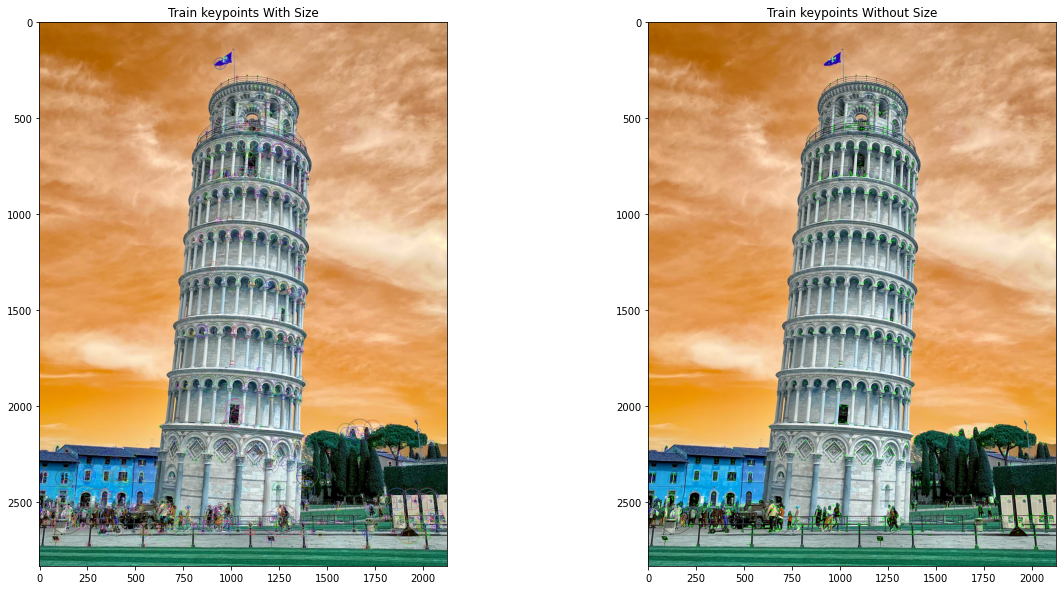

In [25]:
surf = cv2.xfeatures2d.SURF_create(8000)

train_keypoints, train_descriptor = surf.detectAndCompute(img_train, None)
test_keypoints, test_descriptor = surf.detectAndCompute(img_test, None)

keypoints_without_size = np.copy(img_train)
keypoints_with_size = np.copy(img_train)

cv2.drawKeypoints(img_train, train_keypoints, keypoints_without_size, color = (0, 255, 0))

cv2.drawKeypoints(img_train, train_keypoints, keypoints_with_size, flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display image with and without keypoints size
fx, plots = plt.subplots(1, 2, figsize=(20,10))

plots[0].set_title("Train keypoints With Size")
plots[0].imshow(keypoints_with_size, cmap='gray')

plots[1].set_title("Train keypoints Without Size")
plots[1].imshow(keypoints_without_size, cmap='gray')

# Print the number of keypoints detected in the training image
print("Number of Keypoints Detected In The Training Image: ", len(train_keypoints))

# Print the number of keypoints detected in the query image
print("Number of Keypoints Detected In The Query Image: ", len(test_keypoints))

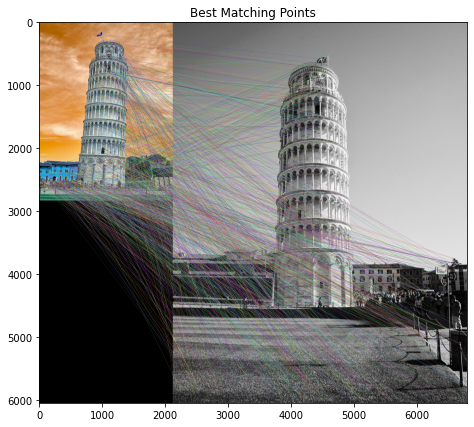


Number of Matching Keypoints Between The Training and Query Images:  1778


In [26]:
# Create a Brute Force Matcher object.
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck = False)

# Perform the matching between the SURF descriptors of the training image and the test image
matches = bf.match(train_descriptor, test_descriptor)

# The matches with shorter distance are the ones we want.
matches = sorted(matches, key = lambda x : x.distance)

result = cv2.drawMatches(img_train, train_keypoints, gray_test, test_keypoints, matches, gray_test, flags = 2)

# Display the best matching points
plt.rcParams['figure.figsize'] = [14.0, 7.0]
plt.title('Best Matching Points')
plt.imshow(result)
plt.show()

# Print total number of matching points between the training and query images
print("\nNumber of Matching Keypoints Between The Training and Query Images: ", len(matches))

## Q6

In [31]:
os.listdir("/content/drive/MyDrive/cvcodingassignment/input")

['training_real', 'training_fake']

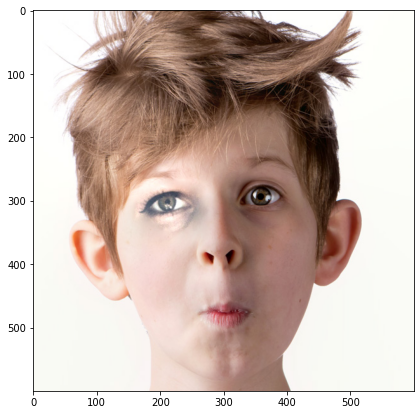

In [33]:
path = os.path.join("input", 'training_fake')
path = os.path.join(path, "/content/drive/MyDrive/cvcodingassignment/input/training_fake/easy_104_1000.jpg")
path
plt.imshow(plt.imread(path))

In [34]:
# path ="archive (1)/real_and_f#renaming real and fake directories
real = "/content/drive/MyDrive/cvcodingassignment/input/training_real"
fake = "/content/drive/MyDrive/cvcodingassignment/input/training_fake"
#we're creating a list of real and fake images
real_path = os.listdir(real)
fake_path = os.listdir(fake)

In [35]:
img_size = int(128)
def create_data():
    training_data = []
    y=[]
    for img in real_path:
        path = os.path.join(real, img)
        # label = [1] 
        try:
            image = cv2.resize( cv2.imread(path,0), (img_size,img_size) )
            training_data.append(np.array(image))
            y.append(1)
        except:
            continue
        
    for img in fake_path:
        path = os.path.join(fake, img)
        # label = [0] 
        try:
            image = cv2.resize(cv2.imread(path,0), (img_size,img_size))
            training_data.append(np.array(image))  
            y.append(0)
        except: continue
        
    return(training_data,y)
data_gray,labels = create_data()
data_gray = np.array(data_gray)
labels = np.array(labels)

In [36]:
data_gray.shape

(2041, 128, 128)

In [44]:
X_train, X_test, y_train, y_test = train_test_split(data_gray, labels, test_size=0.1, random_state=42, stratify=labels, shuffle=True)
X_train.shape

(1836, 128, 128)

In [45]:
ppc = 16
X_train_hog_images = []
X_train_hog_features = []
for image in X_train:
    fd,hog_image = hog(image, orientations=8, pixels_per_cell=(ppc,ppc),cells_per_block=(4, 4),block_norm= 'L2',visualize=True)
    X_train_hog_images.append(hog_image)
    X_train_hog_features.append(fd)


X_test_hog_images = []
X_test_hog_features = []
for image in X_test:
    fd,hog_image = hog(image, orientations=8, pixels_per_cell=(ppc,ppc),cells_per_block=(4, 4),block_norm= 'L2',visualize=True)
    X_test_hog_images.append(hog_image)
    X_test_hog_features.append(fd)

#labels =  np.array(labels).reshape(len(labels),1)

In [46]:
X_train_hog_features = np.array(X_train_hog_features)
X_train_hog_features = pd.DataFrame(X_train_hog_features)
X_train_hog_features['target'] = y_train
train_df = pd.DataFrame(X_train_hog_features)


X_test_hog_features = np.array(X_test_hog_features)
X_test_hog_features = pd.DataFrame(X_test_hog_features)
X_test_hog_features['target'] = y_test
test_df = pd.DataFrame(X_test_hog_features)
train_df.head()

0         1         2         3         4         5         6  \
0  0.021749  0.245409  0.601215  0.244479  0.054088  0.004761  0.004610   
1  0.021408  0.017227  0.006723  0.003453  0.012969  0.002971  0.006556   
2  0.049586  0.004171  0.008791  0.003714  0.010396  0.022669  0.113663   
3  0.005165  0.025919  0.012886  0.005335  0.022001  0.010634  0.008767   
4  0.028922  0.006210  0.007254  0.002873  0.008487  0.004817  0.011932   

          7         8         9  ...      3191      3192      3193      3194  \
0  0.003486  0.077657  0.085987  ...  0.018849  0.047510  0.012551  0.024028   
1  0.004342  0.041729  0.054799  ...  0.151178  0.152706  0.051521  0.034182   
2  0.107708  0.022764  0.031229  ...  0.009206  0.037027  0.021805  0.031233   
3  0.001340  0.012901  0.234665  ...  0.001156  0.011608  0.006484  0.016063   
4  0.022489  0.043662  0.020953  ...  0.022302  0.021155  0.023970  0.030040   

       3195      3196      3197      3198      3199  target  
0  0.020113  0.068617  0.081063  0.152884  0.088204       1  
1  0.016710  0.049065  0.052601  0.109754  0.134787       1  
2  0.018913  0.037785  0.017497  0.028750  0.023533       1  
3  0.020579  0.038230  0.006026  0.008135  0.000887       0  
4  0.022720  0.029534  0.013042  0.011807  0.010002       1  

[5 rows x 3201 columns]

In [47]:
test_df.head()

0         1         2         3         4         5         6  \
0  0.000631  0.000000  0.000000  0.000000  0.000631  0.000000  0.000000   
1  0.005889  0.001666  0.006446  0.001309  0.007237  0.001779  0.006247   
2  0.003702  0.000000  0.002368  0.000000  0.003966  0.000000  0.002119   
3  0.107765  0.031561  0.049059  0.035116  0.044946  0.031835  0.041746   
4  0.012859  0.006850  0.008003  0.007068  0.013003  0.005619  0.007594   

          7         8         9  ...      3191      3192      3193      3194  \
0  0.000000  0.018516  0.043070  ...  0.045888  0.064094  0.032877  0.018755   
1  0.000523  0.008222  0.015850  ...  0.087842  0.161548  0.009879  0.004979   
2  0.000000  0.003358  0.049132  ...  0.042448  0.070533  0.010942  0.010019   
3  0.102971  0.097555  0.089266  ...  0.009812  0.043178  0.154645  0.451480   
4  0.002608  0.015714  0.008960  ...  0.147105  0.100413  0.017053  0.007838   

       3195      3196      3197      3198      3199  target  
0  0.017234  0.075793  0.071574  0.095659  0.072545       1  
1  0.000526  0.002705  0.000969  0.004849  0.016348       1  
2  0.025944  0.071798  0.076703  0.200335  0.164580       0  
3  0.022683  0.041072  0.001021  0.001870  0.006286       1  
4  0.012134  0.052411  0.055013  0.111718  0.093431       0  

[5 rows x 3201 columns]

In [48]:
train_df['target'].unique()

array([1, 0])

In [49]:
svc = SVC(verbose=1, random_state=42)
svc.fit(train_df.drop(['target'], axis=1), train_df['target'])
print(svc.score(train_df.drop(['target'], axis=1), train_df['target']))
print(svc.score(test_df.drop(['target'], axis=1), test_df['target']))
print(metrics.classification_report(y_test, svc.predict(test_df.drop(['target'], axis=1))))

[LibSVM]0.8720043572984749
0.6487804878048781
              precision    recall  f1-score   support

           0       0.64      0.57      0.60        96
           1       0.66      0.72      0.68       109

    accuracy                           0.65       205
   macro avg       0.65      0.64      0.64       205
weighted avg       0.65      0.65      0.65       205



In [50]:
## SVM with CNN features

In [51]:
X_train, X_test, y_train, y_test = train_test_split(data_gray, labels, test_size=0.1, random_state=42, stratify=labels, shuffle=True)
X_train.shape

(1836, 128, 128)

In [56]:
# Normalize pixel values to between 0 and 1
X_train, x_test = X_train / 255.0, X_test / 255.0

#One hot encode y values for neural network. 
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

In [57]:
X_train.shape

(1836, 128, 128)

In [58]:
y_train_one_hot

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [59]:
activation = 'sigmoid'
SIZE=128
feature_extractor = Sequential()
feature_extractor.add(Conv2D(8, 3, activation = activation, padding = 'same', input_shape = (SIZE, SIZE, 1)))
feature_extractor.add(BatchNormalization())

feature_extractor.add(Conv2D(8, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
feature_extractor.add(BatchNormalization())
feature_extractor.add(MaxPooling2D())

feature_extractor.add(Conv2D(16, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
feature_extractor.add(BatchNormalization())

feature_extractor.add(Conv2D(32, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
feature_extractor.add(BatchNormalization())
feature_extractor.add(MaxPooling2D())

feature_extractor.add(Flatten())

#Add layers for deep learning prediction
x = feature_extractor.output  
x = Dense(128, activation = activation, kernel_initializer = 'he_uniform')(x)
prediction_layer = Dense(2, activation = 'softmax')(x)

# Make a new model combining both feature extractor and x
cnn_model = Model(inputs=feature_extractor.input, outputs=prediction_layer)
cnn_model.compile(optimizer='rmsprop',loss = 'categorical_crossentropy', metrics = ['accuracy'])
print(cnn_model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 128, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 8)       80        
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 8)      32        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 8)       584       
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 8)      32        
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 8)        0     

Epoch 1/50
58/58 [==============================] - 53s 872ms/step - loss: 0.9748 - accuracy: 0.5300 - val_loss: 0.6945 - val_accuracy: 0.4683
Epoch 2/50
58/58 [==============================] - 51s 887ms/step - loss: 0.7123 - accuracy: 0.5392 - val_loss: 0.7099 - val_accuracy: 0.4683
Epoch 3/50
58/58 [==============================] - 51s 875ms/step - loss: 0.6951 - accuracy: 0.5594 - val_loss: 0.7270 - val_accuracy: 0.4732
Epoch 4/50
58/58 [==============================] - 51s 871ms/step - loss: 0.6804 - accuracy: 0.5899 - val_loss: 0.6993 - val_accuracy: 0.4683
Epoch 5/50
58/58 [==============================] - 50s 857ms/step - loss: 0.6522 - accuracy: 0.6160 - val_loss: 0.6998 - val_accuracy: 0.4927
Epoch 6/50
58/58 [==============================] - 51s 875ms/step - loss: 0.6600 - accuracy: 0.6024 - val_loss: 0.6906 - val_accuracy: 0.5317
Epoch 7/50
58/58 [==============================] - 51s 877ms/step - loss: 0.6451 - accuracy: 0.6253 - val_loss: 0.7272 - val_accuracy: 0.4780

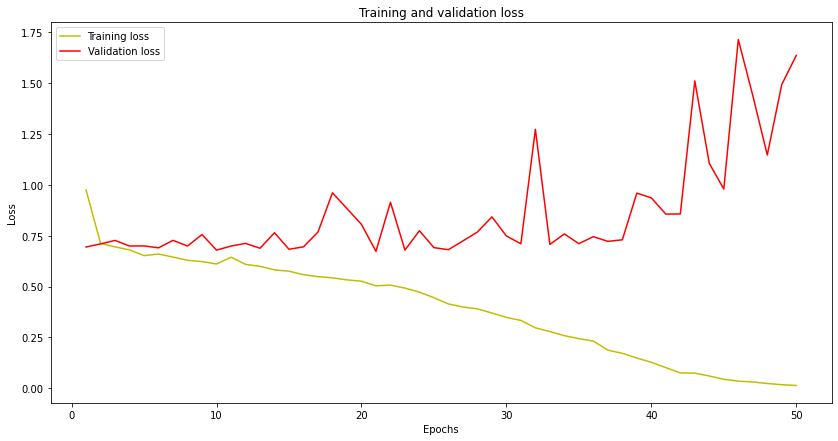

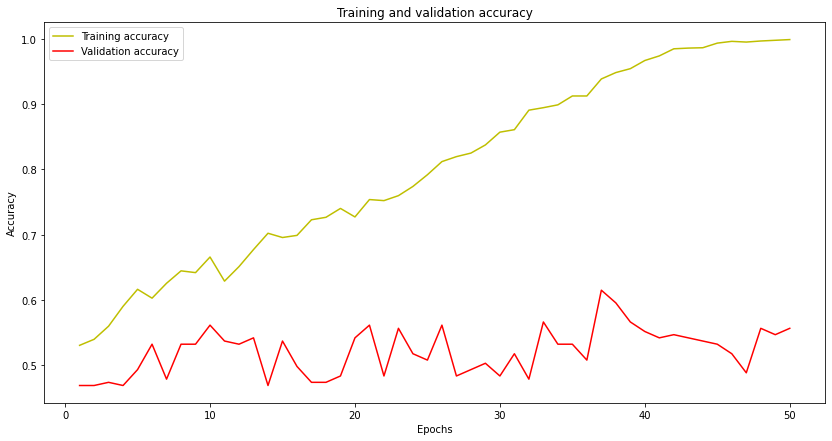

In [60]:
#Train the CNN model
history = cnn_model.fit(X_train, y_train_one_hot, epochs=50, validation_data = (X_test, y_test_one_hot))


#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [62]:
prediction_NN = cnn_model.predict(x_test)
prediction_NN = np.argmax(prediction_NN, axis=-1)
prediction_NN

array([1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 0, 0, 1, 0])

[[43 53]
 [42 67]]


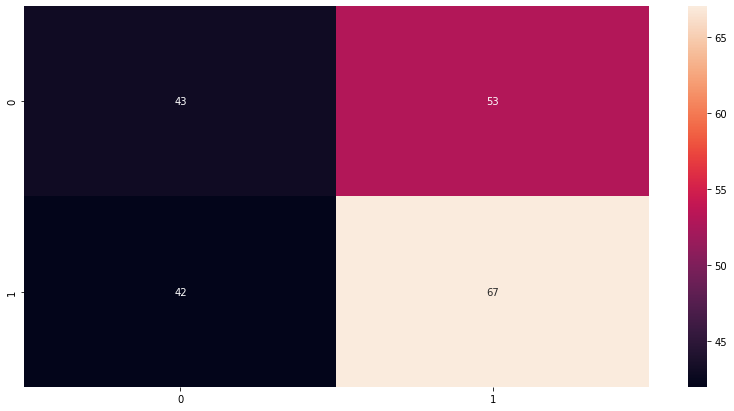

In [63]:
cm = metrics.confusion_matrix(y_test, prediction_NN)
print(cm)
sns.heatmap(cm, annot=True)

In [64]:
#Now, let us use features from convolutional network for RF
X_for_RF = feature_extractor.predict(X_train) #This is out X input to RF

SVC_model = SVC(random_state = 42)

# Train the model on training data
SVC_model.fit(X_for_RF, y_train) #For sklearn no one hot encoding

#Send test data through same feature extractor process
X_test_feature = feature_extractor.predict(X_test)
#Now predict using the trained RF model. 
prediction_RF = SVC_model.predict(X_test_feature)

Accuracy =  0.5317073170731708


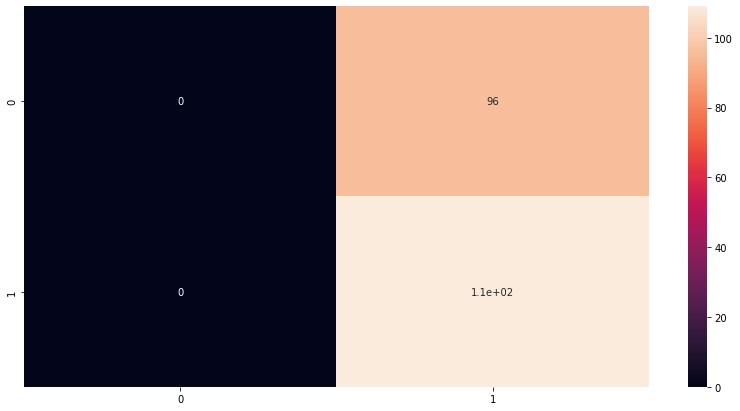

In [66]:
print ("Accuracy = ", metrics.accuracy_score(y_test, prediction_RF))

#Confusion Matrix - verify accuracy of each class
cm = metrics.confusion_matrix(y_test, prediction_RF)
#print(cm)
sns.heatmap(cm, annot=True)

## Q7

In [67]:
X, y = datasets.fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)

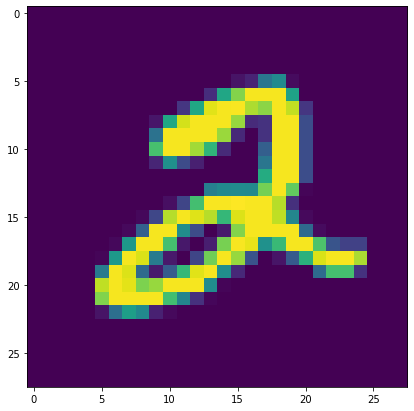

In [86]:
plt.imshow(X[5,:].reshape(28,28))
plt.show()

In [88]:
X_df = []
for i in range(X.shape[0]):
    X_df.append(np.array(X[i]).reshape(28,28))
X_df = np.array(X_df)
X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.1, random_state=42, stratify=y, shuffle=True)
print(X_train.shape)

(63000, 28, 28)


In [89]:
ppc = 8
X_train_hog_images = []
X_train_hog_features = []
for image in X_train:
    fd,hog_image = hog(image, orientations=8, pixels_per_cell=(ppc,ppc),cells_per_block=(2, 2),block_norm= 'L2',visualize=True)
    X_train_hog_images.append(hog_image)
    X_train_hog_features.append(fd)


X_test_hog_images = []
X_test_hog_features = []
for image in X_test:
    fd,hog_image = hog(image, orientations=8, pixels_per_cell=(ppc,ppc),cells_per_block=(2, 2),block_norm= 'L2',visualize=True)
    X_test_hog_images.append(hog_image)
    X_test_hog_features.append(fd)

In [90]:
rfc = RandomForestClassifier(max_depth=3, random_state=42, n_estimators=150)
rfc.fit(X_train_hog_features, y_train)
print(metrics.classification_report(y_test, rfc.predict(X_test_hog_features)))

              precision    recall  f1-score   support

           0       0.82      0.81      0.81       690
           1       0.89      0.96      0.92       788
           2       0.82      0.75      0.78       699
           3       0.57      0.76      0.65       714
           4       0.80      0.72      0.75       682
           5       0.69      0.84      0.76       631
           6       0.82      0.87      0.85       688
           7       0.65      0.89      0.75       729
           8       0.93      0.39      0.55       683
           9       0.76      0.53      0.62       696

    accuracy                           0.75      7000
   macro avg       0.77      0.75      0.74      7000
weighted avg       0.77      0.75      0.75      7000



In [91]:
## MNIST_CNN
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y, shuffle=True)
print(X_train.shape)

# Normalize pixel values to between 0 and 1
X_train, x_test = X_train / 255.0, X_test / 255.0

#One hot encode y values for neural network. 
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)


#input image size 28*28
img_rows , img_cols = 28, 28

(63000, 784)


In [92]:
#reshaping
#this assumes our data format
#For 3D data, "channels_last" assumes (conv_dim1, conv_dim2, conv_dim3, channels) while 
#"channels_first" assumes (channels, conv_dim1, conv_dim2, conv_dim3).
if k.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
#more reshaping
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (63000, 28, 28, 1)
63000 train samples
7000 test samples


In [93]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(10, activation='softmax'))
# compile model
opt = SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [94]:
history = model.fit(X_train, y_train_one_hot, epochs=10, batch_size=32, validation_data=(X_test, y_test_one_hot), verbose=0)
_, acc = model.evaluate(X_test, y_test_one_hot, verbose=0)  # evaluate model

In [95]:
acc

0.8761428594589233

In [100]:
## ResNet50
X.shape

(500, 784)

In [101]:
X = X[:500]
y = y[:500]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y, shuffle=True)
print(X_train.shape)

# Normalize pixel values to between 0 and 1
X_train, x_test = X_train / 255.0, X_test / 255.0

#One hot encode y values for neural network. 
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

(450, 784)


In [102]:
X_train = np.array(X_train).reshape(-1, 28, 28, 1)
def change_size(image):
    img = array_to_img(image, scale=False) #returns PIL Image
    img = img.resize((75, 75)) #resize image
    img = img.convert(mode='RGB') #makes 3 channels
    arr = img_to_array(img) #convert back to array
    return arr.astype(np.float16)

X_train_arr = [change_size(img) for img in X_train]
#del train_arr
X_train = np.array(X_train_arr)
X_train.shape

X_test = np.array(X_test).reshape(-1, 28, 28, 1)
def change_size(image):
    img = array_to_img(image, scale=False) #returns PIL Image
    img = img.resize((75, 75)) #resize image
    img = img.convert(mode='RGB') #makes 3 channels
    arr = img_to_array(img) #convert back to array
    return arr.astype(np.float16)

X_test_arr = [change_size(img) for img in X_test]
#del train_arr
X_test = np.array(X_test_arr)
X_test.shape

(50, 75, 75, 3)

In [103]:
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.1, width_shift_range=0.2, height_shift_range=0.2,validation_split=0.2) #easier for network to interpret numbers in range [0,1]

train_generator = image_gen.flow(X_train, y_train_one_hot, batch_size=64, shuffle=True,subset='training', seed=42)
valid_generator = image_gen.flow(X_test,y_test_one_hot, batch_size=32,shuffle=True, subset='validation')

In [104]:
model = Sequential()

model.add(ResNet50(input_shape = (75, 75, 3), 
                                include_top = False, 
                                weights = 'imagenet'))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

94781440/94765736 [==============================] - 1s 0us/step


In [105]:
for layer in model.layers[0].layers:
    if layer.name == 'conv5_block1_0_conv':
        break
    layer.trainable=False

In [106]:
history = model.fit(train_generator, validation_data=valid_generator, epochs=5,steps_per_epoch=train_generator.n//train_generator.batch_size,validation_steps=valid_generator.n//valid_generator.batch_size)

Epoch 1/5
5/5 [==============================] - 54s 8s/step - loss: 4.1411 - accuracy: 0.0912
Epoch 2/5
5/5 [==============================] - 55s 12s/step - loss: 3.2431 - accuracy: 0.1115
Epoch 3/5
5/5 [==============================] - 42s 8s/step - loss: 2.8592 - accuracy: 0.1250
Epoch 4/5
5/5 [==============================] - 42s 9s/step - loss: 2.7081 - accuracy: 0.1216
Epoch 5/5
5/5 [==============================] - 45s 9s/step - loss: 2.4997 - accuracy: 0.1562


In [107]:
y_pred = model.predict(X_test, batch_size=16)

## Optical Flow

No frames grabbed!


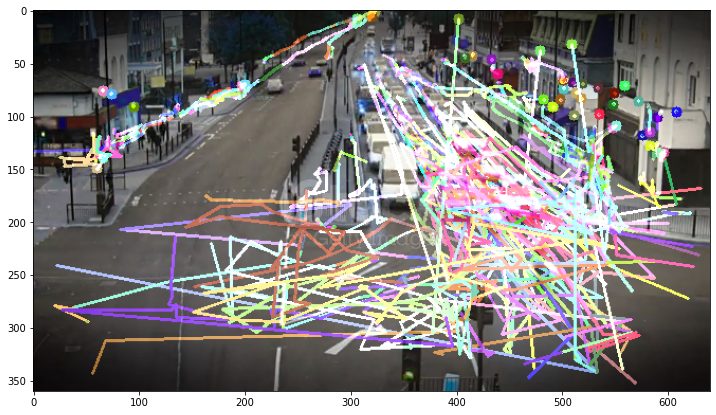

In [109]:
cap = cv2.VideoCapture("/content/drive/MyDrive/cvcodingassignment/istockphoto-472581435-640_adpp_is.mp4")
# params for ShiTomasi corner detection
feature_params = dict( maxCorners = 100,
                       qualityLevel = 0.3,
                       minDistance = 7,
                       blockSize = 7 )
# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (15, 15),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
# Create some random colors
color = np.random.randint(0, 255, (100, 3))
# Take first frame and find corners in it
ret, old_frame = cap.read()
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
p0 = cv2.goodFeaturesToTrack(old_gray, mask = None, **feature_params)
# Create a mask image for drawing purposes
mask = np.zeros_like(old_frame)
while(1):
    ret, frame = cap.read()
    if not ret:
        print('No frames grabbed!')
        break
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # calculate optical flow
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)
    # Select good points
    if p1 is not None:
        good_new = p1[st==1]
        good_old = p0[st==1]
    # draw the tracks
    for i, (new, old) in enumerate(zip(good_new, good_old)):
        a, b = new.ravel()
        c, d = old.ravel()
        mask = cv2.line(mask, (int(a), int(b)), (int(c), int(d)), color[i].tolist(), 2)
        frame = cv2.circle(frame, (int(a), int(b)), 5, color[i].tolist(), -1)
    img = cv2.add(frame, mask)
    plt.imshow( img)
 
    # Now update the previous frame and previous points
    old_gray = frame_gray.copy()
    p0 = good_new.reshape(-1, 1, 2)